In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [4]:
# structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [500] # (200: 100 um, 500: 250 um)
# surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
#                              for m in margins_to_sample
#                              for s in structures_to_sample 
#                              for surr_l in structures_to_sample + ['noclass'] 
#                              if surr_l != s]

# labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Train Classifiers

In [5]:
classifier_settings

,model,margin,train_set_id,neg_composition,sample_weighting
classifier_id,,,,,
30,lr,500,20/21,neg_has_all_surround,NaN
31,lr,500,21/22,neg_has_all_surround,NaN
32,lr,500,20/22,neg_has_all_surround,NaN
33,gb1,500,20/21,neg_has_all_surround,NaN
34,gb1,500,21/22,neg_has_all_surround,NaN
35,gb1,500,20/22,neg_has_all_surround,NaN
95,gb2,500,93,neg_has_all_surround,NaN
96,gb2,500,95,neg_has_all_surround,NaN
97,gb2,500,97,neg_has_all_surround,NaN


In [6]:
classifier_id = 100
classifier_properties = classifier_settings.loc[classifier_id]

margin = classifier_properties['margin']
model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']

In [7]:
# Determine which labels to load.

structures_to_sample = all_known_structures
negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [margin] # (200: 100 um, 500: 250 um)
surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample
                             if surr_l != s]
surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

if neg_composition == 'neg_has_everything_else':
    labels_to_sample = structures_to_sample + negative_labels_to_sample
elif neg_composition == 'neg_has_only_surround_noclass':
    labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_all_surround':
    labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']

In [8]:
# Load training dataset.

training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
# training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample)
training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample, 
                                                      clf_rootdir=CELL_FEATURES_CLF_ROOTDIR)
    
assert set(training_addresses.keys()) == set(training_features.keys()), \
    'Training features and training addresses are not consistent.'

In [9]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

In [10]:
# setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))
setting_dir = os.path.join(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [11]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('neg_composition %s is not recognized.' % neg_composition)

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
#     if setting == 9:
    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
#     if setting in [1, 2, 8, 9, 10, 11, 23, 24]:
    if model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
#     elif setting == 3:
    elif model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

#     elif setting == 4:
    elif model == 'lin_svc_calib':
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
#     elif setting in [5]:        
    elif model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#     elif setting in [6, 25]:
    elif model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
#     elif setting in [7, 26]:     
    elif model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    clf_fp = os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=classifier_id))
    
    joblib.dump(clf, clf_fp)
    
    upload_to_s3(clf_fp)

Tz
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/Tz_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/Tz_clf_setting_100.dump


Fitting classifier: 0.01 seconds
Child returned 0
0.80 seconds.
Fitting classifier: 0.02 seconds


Sp5O
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/Sp5O_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/Sp5O_clf_setting_100.dump


Child returned 0
0.79 seconds.
Fitting classifier: 0.01 seconds


7n
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/7n_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/7n_clf_setting_100.dump


Child returned 0
0.82 seconds.
Fitting classifier: 0.02 seconds


DC
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/DC_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/DC_clf_setting_100.dump


Child returned 0
0.74 seconds.
Fitting classifier: 0.01 seconds


5N
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/5N_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/5N_clf_setting_100.dump


Child returned 0
0.76 seconds.
Fitting classifier: 0.00 seconds


RtTg
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/RtTg_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/RtTg_clf_setting_100.dump


Child returned 0
0.75 seconds.
Fitting classifier: 0.01 seconds


Pn
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/Pn_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/Pn_clf_setting_100.dump


Child returned 0
0.71 seconds.
Fitting classifier: 0.01 seconds


10N
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/10N_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/10N_clf_setting_100.dump


Child returned 0
0.73 seconds.
Fitting classifier: 0.01 seconds


LC
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/LC_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/LC_clf_setting_100.dump


Child returned 0
0.73 seconds.
Fitting classifier: 0.01 seconds


7N
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/7N_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/7N_clf_setting_100.dump


Child returned 0
0.74 seconds.
Fitting classifier: 0.00 seconds


Amb
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/Amb_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/Amb_clf_setting_100.dump


Child returned 0
0.69 seconds.
Fitting classifier: 0.01 seconds


12N
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/12N_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/12N_clf_setting_100.dump


Child returned 0
0.70 seconds.
Fitting classifier: 0.01 seconds


RMC
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/RMC_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/RMC_clf_setting_100.dump


Child returned 0
0.71 seconds.
Fitting classifier: 0.02 seconds


VCA
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/VCA_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/VCA_clf_setting_100.dump


Child returned 0
0.74 seconds.
Fitting classifier: 0.02 seconds


Sp5I
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/Sp5I_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/Sp5I_clf_setting_100.dump


Child returned 0
0.68 seconds.
Fitting classifier: 0.01 seconds


Sp5C
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/Sp5C_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/Sp5C_clf_setting_100.dump


Child returned 0
0.69 seconds.
Fitting classifier: 0.02 seconds


VCP
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/VCP_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/VCP_clf_setting_100.dump


Child returned 0
0.68 seconds.
Fitting classifier: 0.00 seconds


AP
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/AP_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/AP_clf_setting_100.dump


Child returned 0
0.54 seconds.
Fitting classifier: 0.01 seconds


PBG
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/PBG_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/PBG_clf_setting_100.dump


Child returned 0
0.73 seconds.
Fitting classifier: 0.01 seconds


LRt
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/LRt_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/LRt_clf_setting_100.dump


Child returned 0
0.67 seconds.
Fitting classifier: 0.01 seconds


IC
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/IC_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/IC_clf_setting_100.dump


Child returned 0
0.67 seconds.
Fitting classifier: 0.01 seconds


VLL
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/VLL_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/VLL_clf_setting_100.dump


Child returned 0
0.69 seconds.
Fitting classifier: 0.01 seconds


SNC
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/SNC_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/SNC_clf_setting_100.dump


Child returned 0
0.53 seconds.
Fitting classifier: 0.00 seconds


6N
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/6N_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/6N_clf_setting_100.dump


Child returned 0
0.58 seconds.
Fitting classifier: 0.01 seconds


SNR
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/SNR_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/SNR_clf_setting_100.dump


Child returned 0
0.59 seconds.
Fitting classifier: 0.01 seconds


SC
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/SC_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/SC_clf_setting_100.dump


Child returned 0
0.49 seconds.
Fitting classifier: 0.01 seconds


3N
aws s3 cp /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/3N_clf_setting_100.dump s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/3N_clf_setting_100.dump


Child returned 0
0.55 seconds.


# Load pre-computed classifiers, measure training accuracy

In [12]:
classifier_id = 100

In [13]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':classifier_id})
    download_from_s3_to_ec2(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/4N_clf_setting_100.dump && mkdir -p /shared/CSHL_cells_v2/classifiers/setting_100/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/4N_clf_setting_100.dump /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/4N_clf_setting_100.dump


Child returned 0
Child returned 1
0.75 seconds.
Classifier for 4N is not found.
Child returned 0


rm -rf /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/sp5_clf_setting_100.dump && mkdir -p /shared/CSHL_cells_v2/classifiers/setting_100/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/sp5_clf_setting_100.dump /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/sp5_clf_setting_100.dump


Child returned 1
0.70 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/outerContour_clf_setting_100.dump && mkdir -p /shared/CSHL_cells_v2/classifiers/setting_100/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/classifiers/setting_100/classifiers/outerContour_clf_setting_100.dump /shared/CSHL_cells_v2/classifiers/setting_100/classifiers/outerContour_clf_setting_100.dump


Child returned 1
0.74 seconds.
Classifier for outerContour is not found.


In [14]:
margin = 500
neg_composition = 'neg_has_all_surround'

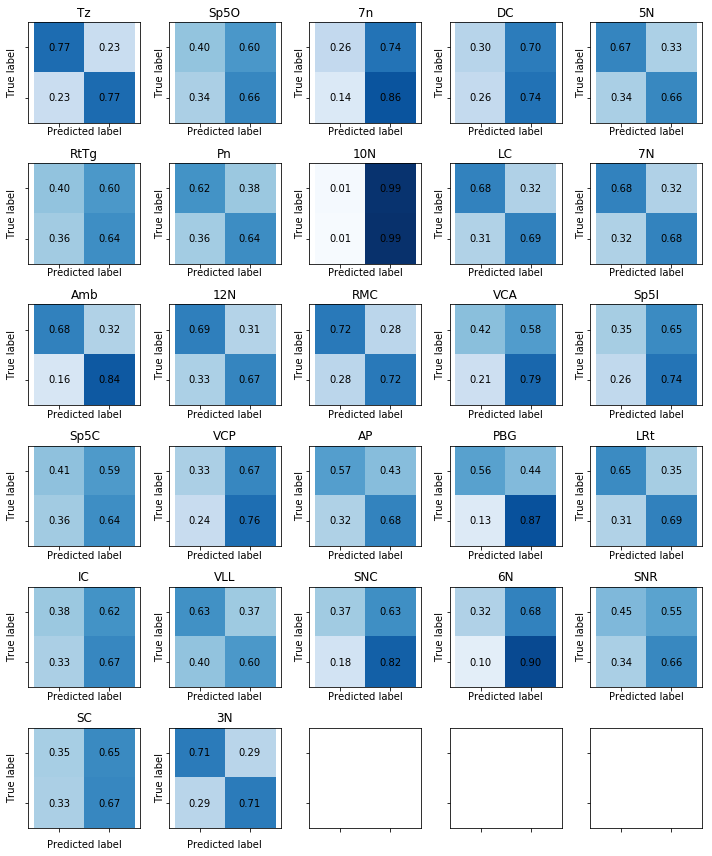

In [15]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
#     if setting in [1, 3, 4, 5, 6, 7]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
#         for surr_l in structures_found:
#             c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
#             if c in labels_found:
#                 neg_classes.append(c)
#     elif setting in [8,9,11]:
#         neg_classes = [structure + '_negative']
#     else:
#         sys.stderr.write('Setting is not recognized.\n')
#         raise

#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')
        
        
    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [16]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.677897861571


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (185246720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


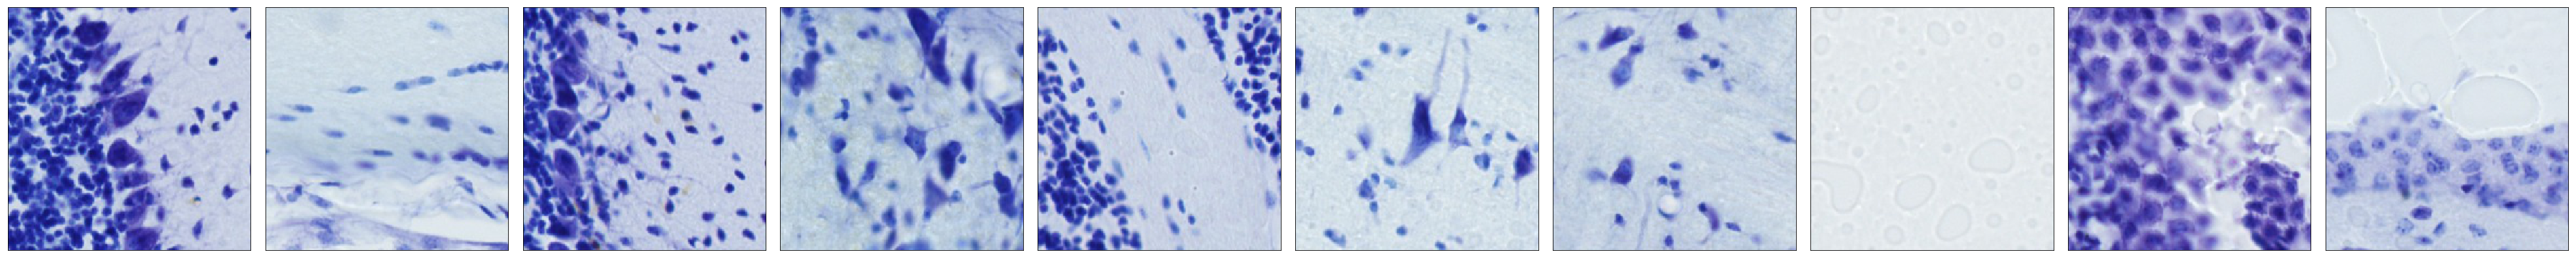

In [17]:
# Visualize training patches

patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
                                                            location_or_grid_index='grid_index',
                                                            version='compressed')
display_images_in_grids(patches, nc=10)

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N_surround'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

In [18]:
def patch_boxes_overlay_on(bg, downscale_factor, locs, patch_size, colors=None, stack=None, sec=None):
    """
    Assume bg has the specified downscale_factor.
    """

    if bg == 'original':
        bg = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='compressed'))[::downscale_factor, ::downscale_factor]
       
    # viz = bg.copy()
    viz = gray2rgb(bg).copy()
    # need copy() because of this bug http://stackoverflow.com/a/31316516
    
    half_size = patch_size/2/downscale_factor
    if isinstance(locs[0], list):
        if colors is None:
            colors = random_colors(len(locs))
        for i, locs_oneColor in enumerate(locs):
            for x, y in locs_oneColor:
                x = x / downscale_factor
                y = y / downscale_factor
                cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors[i], 2)
    else:
        if colors is None:
            colors = (255,0,0)
        for x, y in locs:
            x = x / downscale_factor
            y = y / downscale_factor
            cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors, 2)
            
    return viz

In [19]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

/shared/MouseBrainAtlasXiang/learning/tmp.jpg